<a href="https://colab.research.google.com/github/santiagoprado12/Tesis/blob/main/Hallando_Beta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize

In [ ]:
df = pd.read_csv(r'Casos diarios.csv')

In [ ]:
the_gamma = 1/21

In [ ]:
df

,fechas,casos por dia,fallecidos por dia,recuperados por dia,sintomaticos activos,expuestos,acumulado muertes,acumulado recuperados,acumulado casos,acumulado sintomaticos,acumulado expuestos,activos por dia,asintomaticos
0,2020-02-27,1,0,0,1,14,0,0,0,0,0,0,0
1,2020-02-28,1,0,0,1,13,0,0,1,1,14,1,0
2,2020-02-29,2,0,0,2,9,0,0,2,2,27,2,0
3,2020-03-01,5,0,0,5,17,0,0,4,4,36,4,0
4,2020-03-02,4,0,0,4,33,0,0,9,9,53,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,2021-01-27,6797,333,16583,-10051,-3277,53401,1847091,2146621,221163,66298,246129,24966
336,2021-01-28,6440,316,16404,-11297,-2006,53734,1863674,2153418,211112,63021,236010,24898
337,2021-01-29,5805,316,16439,-11863,-1945,54050,1880078,2159858,199815,61015,225730,25915
338,2021-01-30,4702,296,14922,-9156,-3812,54366,1896517,2165663,187952,59070,214780,26828


In [ ]:
def derivSIR(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

def derivSEIR(y, t, N, beta, gamma, sigma):
    S, E, I, R = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - sigma * E
    dIdt = sigma * E - gamma*I
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt 

In [ ]:
def modelSIR(V,R,N,beta,gamma):
    t = np.linspace(0,len(V)-1,len(V))
    y0 = N-V[0]-R[0],V[0],R[0]
    S,I,R = odeint(derivSIR, y0, t, args=(N, beta, gamma)).T
    dV = V
    dI = I
    return np.linalg.norm(dV-dI)

def modelSEIR(Ex,V,R,N,beta,gamma,sigma):
    t = np.linspace(0,len(V)-1,len(V))
    y0 = N - Ex[0] - V[0] - R[0], Ex[0], V[0], R[0]
    S, E, I, R  = odeint(derivSEIR, y0, t, args=(N, beta, gamma, sigma)).T
    dV = V
    dI = I
    dE = E
    dEx = Ex
    return np.linalg.norm(((dV-dI)**2)+((dE-dEx)**2))

In [ ]:

def fitSIR(V,R,N):
    
    res = minimize(lambda x:modelSIR(V,R,N,x,the_gamma),
                            x0=0.5,method='powell')
    return res.x

def fitSEIR(Ex,V,R,N):
    
    def f(x):
      y1,y2=x
      return modelSEIR(Ex,V,R,N,y1,the_gamma,y2)


    res1 = minimize(f,x0=[0.5,0.5])

    return res1.x

In [ ]:
def compute_paramsSIR(df,population, start_index, ndays):
  for i in range(start_index,len(df)-ndays):
      V = df['Infected'][i:i+ndays].to_numpy()
      R = df['Removed'][i:i+ndays].to_numpy()
      beta = fitSIR(V,R,population)
      df.loc[i,'Beta'] = beta
      df.loc[i,'Gamma'] = the_gamma

def compute_paramsSEIR(df,population, start_index, ndays):
  for i in range(start_index,len(df)-ndays):
      Ex=df['Expuestos'][i:i+ndays].to_numpy()
      V = df['InfectedSEIR'][i:i+ndays].to_numpy()
      R = df['Removed'][i:i+ndays].to_numpy()
      beta, sigma = fitSEIR(Ex,V,R,population)
      df.loc[i,'BetaSEIR'] = beta
      df.loc[i,'Gamma'] = the_gamma
      df.loc[i,'Sigma'] = sigma

S=Poblacion total - Activos - recuperados - muertos

I=Activos

R=Recuperados + Muertos

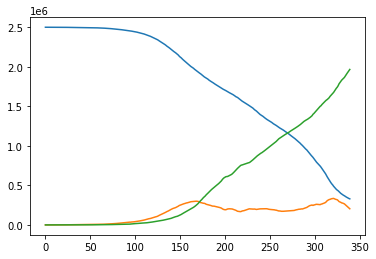

In [ ]:
n=2500000
plt.plot(n-df['activos por dia']-df['acumulado recuperados']-df['acumulado muertes'])
plt.plot(df['activos por dia'])
plt.plot(df['acumulado recuperados']+df['acumulado muertes'])

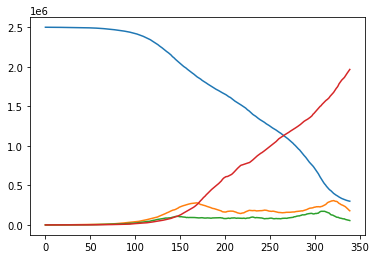

In [ ]:
n=2500000
plt.plot(n-df['acumulado sintomaticos']-df['acumulado expuestos']-df['acumulado recuperados']-df['acumulado muertes'])
plt.plot(df['acumulado sintomaticos'])
plt.plot(df['acumulado expuestos'])
plt.plot(df['acumulado recuperados']+df['acumulado muertes'])

In [ ]:
df['Infected']=df['activos por dia']
df['Recovered']=df['acumulado recuperados']
df['Deaths']=df['acumulado muertes']
df['Removed'] = df['Recovered']+df['Deaths']

In [ ]:
df['InfectedSEIR']=df['acumulado sintomaticos']
df['Expuestos']=df['acumulado expuestos']

In [ ]:
init_index=20
compute_paramsSIR(df,48200000, init_index, 2)
df['Rt'] = df['Beta'] / df['Gamma']

In [ ]:
init_index=20
compute_paramsSEIR(df,48200000, init_index, 2)
#df['Rt'] = df['Beta'] / df['Gamma']

In [ ]:
res=[]
N= 48200000
the_gamma = 1/21
I_a=df['Infected'][init_index]
res=[I_a]
R_a=df['Removed'][init_index]
S_a=N-I_a-R_a

for be in df['Beta'][init_index:]:
  t = np.linspace(0,1,2)
  y0 = S_a,I_a,R_a
  S,I,R = odeint(derivSIR, y0, t, args=(N, be, the_gamma)).T
  I_a=I[1]
  R_a=R[1]
  S_a=S[1]
  res.append(I[1])

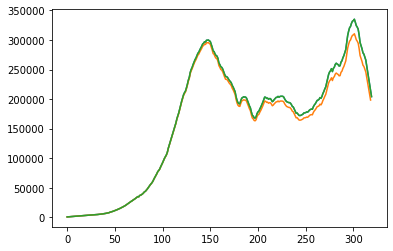

In [ ]:
plt.plot(range(0,len(df['activos por dia'][init_index:])),df['activos por dia'][init_index:])
plt.plot(res)
plt.plot(range(0,len(df['asintomaticos'][init_index:])),df['asintomaticos'][init_index:]+df['acumulado sintomaticos'][init_index:])

In [ ]:
res1=[]
N= 48200000
init_index=20
the_gamma = 1/21
I_a=df['InfectedSEIR'][init_index]
res1=[I_a]
Ex_a=df['Expuestos'][init_index]
R_a=df['Removed'][init_index]
S_a=N-I_a-R_a-Ex_a
sigma1=df['Sigma'][init_index:]

for i,be in enumerate(df['BetaSEIR'][init_index:]):
  sigma=sigma1[i+init_index]
  t = np.linspace(0,1,2)
  y0 = S_a,Ex_a,I_a,R_a
  S,E,I,R = odeint(derivSEIR, y0, t, args=(N, be, the_gamma,sigma)).T
  I_a=I[1]
  Ex_a=E[1]
  R_a=R[1]
  S_a=S[1]
  res1.append(I[1])

In [ ]:
sigma1

20     0.141823
21     0.164904
22     0.203440
23     0.184229
24     0.182041
         ...   
335    0.003703
336   -0.024439
337   -0.043865
338         NaN
339         NaN
Name: Sigma, Length: 320, dtype: float64

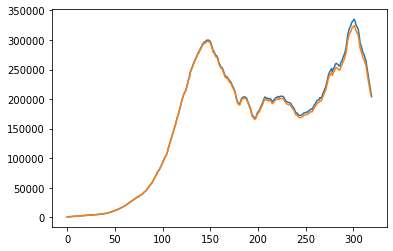

In [ ]:
plt.plot(range(0,len(df['activos por dia'][init_index:])),df['activos por dia'][init_index:])
plt.plot(range(0,len(df['asintomaticos'][init_index:])),df['asintomaticos'][init_index:]+res1[:-1])

In [ ]:
df1 = pd.read_csv(r'Casos diarios.csv')

In [ ]:
df1["Gamma"]=df["Gamma"]

In [ ]:
df1["Beta"]=df["Beta"]

In [ ]:
df1["Sigma"]=df["Sigma"]

In [ ]:
df1["BetaSEIR"]=df["BetaSEIR"]

In [ ]:
df1=df1[20:338]

In [ ]:
df1.to_csv(r'Casos diarios y Beta.csv', index = False)

In [ ]:
df1

,fechas,casos por dia,fallecidos por dia,recuperados por dia,sintomaticos activos,expuestos,acumulado muertes,acumulado recuperados,acumulado casos,acumulado sintomaticos,acumulado expuestos,activos por dia,asintomaticos,Gamma,Beta,Sigma,BetaSEIR
20,2020-03-18,139,0,0,138,16,1,4,768,754,1244,763,9,0.047619,0.214979,0.141823,0.234668
21,2020-03-19,162,0,1,160,-12,1,4,907,892,1260,902,10,0.047619,0.211859,0.164904,0.199767
22,2020-03-20,198,0,1,195,-33,1,5,1069,1052,1248,1063,11,0.047619,0.217641,0.203440,0.188397
23,2020-03-21,160,0,3,156,-46,1,6,1267,1247,1215,1260,13,0.047619,0.165054,0.184229,0.130562
24,2020-03-22,152,1,3,142,-3,1,9,1427,1403,1169,1417,14,0.047619,0.146968,0.182041,0.141889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,2021-01-25,8024,387,17813,-6550,-7056,52658,1812618,2131290,237659,76693,266014,28355,0.047619,0.009013,0.063068,-0.010922
334,2021-01-26,7307,356,16660,-9946,-3339,53045,1830431,2139314,231109,69637,255838,24729,0.047619,0.009345,0.012076,-0.011667
335,2021-01-27,6797,333,16583,-10051,-3277,53401,1847091,2146621,221163,66298,246129,24966,0.047619,0.005900,0.003703,-0.014724
336,2021-01-28,6440,316,16404,-11297,-2006,53734,1863674,2153418,211112,63021,236010,24898,0.047619,0.003229,-0.024439,-0.017959
